# Стохастический градиентный и координатный спуски

Для каждого задания указано количество баллов (если они оцениваются отдельно) + 1 балл за аккуратное и полное выполнение всего задания

## Загрузка и подготовка данных

**Загрузите уже знакомый вам файл *Advertising.csv* как объект DataFrame.** 

In [216]:
import pandas as pd
data = pd.read_csv('./Unit_5_data/Advertising.csv',index_col=0)
data.head(2)

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4


**Проверьте, есть ли в данных пропуски и, если они есть - удалите их**

In [217]:
print (f'Количество пропусков в данных {data.isna().sum().sum()}')

Количество пропусков в данных 0


**Преобразуйте ваши признаки в массивы NumPy и разделите их на переменные X (предикторы) и y(целевая переменная)** 

In [218]:
X, y = data[['TV','radio','newspaper']].values, data.sales.values

## Координатный спуск (3 балла)

**Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [219]:
import numpy as np
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Нормализуем данные: обычно это необходимо для корректной работы алгоритма**

In [220]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

**Реализуйте алгоритм координатного спуска:** (3 балла)

Ниже приведен алгоритм:

<a href="https://ibb.co/Th3BQFn"><img src="https://i.ibb.co/DK2DBS6/zascas.jpg" alt="zascas" border="0"></a>

Примечание: 1000 итераций здесь указаны для этого задания, на самом деле их может быть намного больше, нет детерменированного значения.

Вам необходимо реализовать координатный спуск, и вывести веса в модели линейной регрессии.

In [221]:
predictors_num = X.shape[1]
w_cd = np.zeros(predictors_num)
     
for _ in range(1000):        
    resid = y - X@w_cd   
    for i in range(predictors_num):     
        resid = resid + X[:, i]*w_cd[i]
        w_cd[i] = X[:, i] @ resid
        resid = resid - X[:, i]*w_cd[i]
w_cd

array([ 41.56217205, 110.13144155,  73.52860638,  -0.55006384])

Сравните результаты с реализацией линейной регрессии из библиотеки sklearn:

In [222]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
 
print(model.coef_)

[ 41.56217205 110.13144155  73.52860638  -0.55006384]


Сравнение полученных результатов показывает, что различие    
в коэффтиентах составляет крайне малые величины порядка $10^{-13}, $$10^{-14}$ при величине самих коэффииентов порядка от $10^{-1}$  до $10^{2}$.

In [223]:
w_cd - model.coef_

array([-1.20792265e-13,  4.26325641e-14,  1.42108547e-14,  1.57651669e-14])

Если вы все сделали верно, они должны практически совпасть!

## Стохастический градиентный спуск (6 баллов)

**Отмасштабируйте столбцы исходной матрицы *X* (которую мы не нормализовали еще!). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение** (0.5 баллов)

In [224]:
X_sgd = data[['TV','radio','newspaper']].values
X_sgd = (X_sgd - X_sgd.mean(axis=0))/X_sgd.std(axis=0)

**Добавим единичный столбец**

In [225]:
X_sgd = np.hstack([np.ones(X_sgd.shape[0]).reshape(-1, 1), X_sgd])

**Создайте функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse** (0.5 балла)

In [226]:
def mse_error(y_true,y_pred):
    return ((y_true - y_pred)**2).sum()/len(y_true)

**Сделайте наивный прогноз: предскажите продажи средним значением. После этого рассчитайте среднеквадратичную ошибку для этого прогноза** (0.5 балла)

In [227]:
pred_naive = np.full(y.shape,fill_value = y.mean())
mse_error(y,pred_naive)

27.085743750000002

**Создайте функцию *lin_pred*, которая может по матрице предикторов *X* и вектору весов линейной модели *w* получить вектор прогнозов** (0.5 балла)

In [228]:
def lin_pred(X,w):
    return X@w

**Создайте функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска. (1.5 балла) 
Функция должна принимать на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Для того, чтобы написать функцию, нужно сделать следующее:
    
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным, а потом поделить на количество элементов в выборке.
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска

In [229]:
def stoch_grad_step(X,y,w,train_ind,eta):
    resid = (lin_pred(X,w)-y)[np.newaxis,:]
    observation = X[[train_ind],:]
    w_next = w - eta/len(y)*(observation.T@resid).sum(axis = 1)
    return w_next

**Создайте функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска (2.5 балла)**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

Алгоритм сследующий:
    
* Инициализируйте расстояние между векторами весов на соседних итерациях большим числом (можно бесконечностью)
* Создайте пустой список для фиксации ошибок
* Создайте счетчик итераций
* Реализуйте оновной цикл обучения пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: сгенерируйте случайный индекс, запишите текущую ошибку в вектор ошибок, запишите в переменную текущий шаг стохастического спуска с использованием функции, написанной ранее. Далее рассчитайте текущее расстояние между векторами весов и прибавьте к счетчику итераций 1.
* Верните вектор весов и вектор ошибок

In [230]:
def stochastic_gradient_descent(X,y,w,learning_rate,max_iter,epsilon = 10**-15):
    distance = np.inf # иниилизаия расстояния между векторами весов
    err = []          # вектора ошибок
    iter_count = 0    # счетчика итераий
                        
    while iter_count < max_iter and distance > epsilon:
        train_ind = np.random.randint(len(y))
        w_current = stoch_grad_step(X, y, w, train_ind, learning_rate)
        err_current = mse_error(y,lin_pred(X,w_current))
        err.append(err_current)
        distance = np.linalg.norm(w-w_current)
        w = w_current
        iter_count += 1
    return w,err

 **Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов, состоящий из нулей. Можете поэкспериментировать с параметром, отвечающим за темп обучения.**

Wall time: 6min 8s


Text(0.5, 0, 'learning_rate')

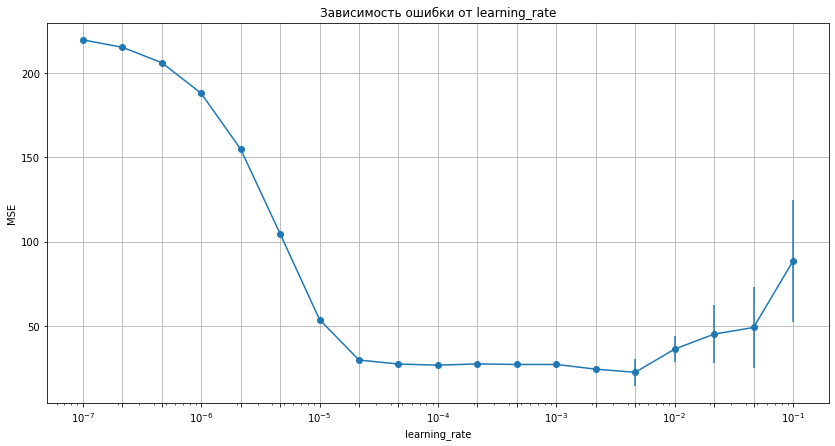

In [231]:
%%time
import matplotlib.pyplot as plt

max_iter = 10**5
w_start = np.zeros(X_sgd.shape[1])
sgd_errors = []
len_rates = []
for lr in np.logspace(-7,-1,num=19):
    test_series = []
    for _ in range(5):
        sgd_res = stochastic_gradient_descent(X_sgd,y,w_start,lr,max_iter)
        test_series += [sgd_res[1][-1]]
    len_rates += [lr]
    sgd_errors += [test_series]

errors_mean = np.array(sgd_errors).mean(axis=1)
errors_std = np.array(sgd_errors).std(axis=1)

plt.figure(figsize=(14,7))
plt.grid(True)
plt.errorbar(len_rates, errors_mean , yerr = errors_std, fmt='o-')
plt.xscale('log')
plt.xticks(len_rates)
plt.title('Зависимость ошибки от learning_rate')
plt.ylabel('MSE')
plt.xlabel("learning_rate");

Как видим устойчивый минимум ошибки достигается при величинах **learning rate** в диапозоне $10^{-4}$ - $10^{-3}$. Чтобы обучаться побыстрее будем пользоваться **learning rate** = $10^{-3}$.

**Постройте график зависимости ошибки от номера итерации**

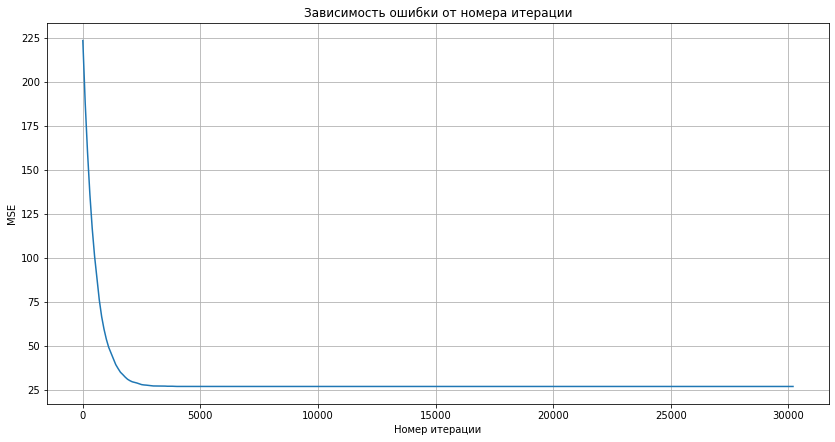

In [238]:
import matplotlib.pyplot as plt

max_iter = 10**5
w_start = np.zeros(X_sgd.shape[1])

learning_rate = 10**-3

sgd_res = stochastic_gradient_descent(X_sgd,y,w_start,learning_rate,max_iter)

errors = sgd_res[1]
step = 100

plt.figure(figsize=(14,7))
plt.grid(True)
plt.plot (list(range(0,len(errors),step)),errors[::step])
plt.title('Зависимость ошибки от номера итерации')
plt.ylabel('MSE')
plt.xlabel("Номер итерации");

**Выведите вектор весов, к которому сошелся метод.**

In [239]:
# [print(f'w_{i} = {w}') for i,w in enumerate(result[0])];
w_sgd = sgd_res[0]
w_sgd

array([14.0225    , -0.05545724,  0.06971556,  0.1291125 ])

**Выведите среднеквадратичную ошибку на последней итерации.**

In [240]:
errors[-1]

26.84207180448602

Оценка качества обеих полученных моделей с помощью **MSE** и **MAE**.

In [241]:
def mae_error(y_true,y_pred):
    return (abs(y_true - y_pred)).sum()/len(y_true)

In [242]:
mse_error(y,X@w_cd),mse_error(y,X_sgd@w_sgd)

(2.784126314510936, 26.84207180448602)

In [243]:
mae_error(y,X@w_cd),mae_error(y,X_sgd@w_sgd)

(1.2520112296870685, 4.2568429301843995)

Как видим алгоритм координатного спуска оказался точнее.
Предположу, что алгоритм SGD пал жертвой неудачного выбора стартовой точки,в следсвие чего мы попали в нелучший локальный минимум.